In [2]:
import pandas as pd
from collections import defaultdict

# First, load a results file
RANKINGS_PATH = "../rankings.csv"
rankings = pd.read_csv(RANKINGS_PATH)

In [3]:
# Fetch all rankings by ID, then put 'em in a dict
data = defaultdict(lambda: {"predicted": {}, "benchmark": {}})
for ranking_id in rankings["ranking_id"].unique():
    params = None
    for i, row in rankings[rankings["ranking_id"] == ranking_id].iterrows():
        # Extract the parameters
        if params is None: params = tuple(row.iloc[2:8])
        elif tuple(row.iloc[2:8]) != params:
            raise TypeError("Unexpected parameters encountered")

        # Sanity check if we are uniquely busy
        if params in data and row["ranking_position"] in data[params]["predicted"]:
            raise TypeError("Not so unique as I thought")
            
        # Store this ranking
        data[params]["predicted"][row["ranking_position"]] = tuple(row.iloc[8:12])
        data[params]["benchmark"][row["ranking_position"]] = tuple(row.iloc[12:16])

# Get rid of the default shit
data = {params: {kind: {rank: data[params][kind][rank] for rank in data[params][kind]} for kind in data[params]} for params in data}

In [4]:
NAMES = ["n_hidden_layers", "nodes_per_layer", "n_epochs", "n_samples", "sample_size", "n_classes"]
NAME_INDEX_MAP = {
    "n_hidden_layers": 0,
    "nodes_per_layer": 1,
    "n_epochs": 2,
    "n_samples": 3,
    "sample_size": 4,
    "n_classes": 5
}
NAME_DEFAULT_MAP = {
    "n_hidden_layers" : 1,
    "nodes_per_layer" : 20,
    "n_epochs" : 500,
    "n_samples" : 500,
    "sample_size" : 50,
    "n_classes" : 10
}

def get_by_var(data, varname):
    """
        This function is able to return all rankings for a certain variable, in increasing order for that variable
        Returns the values of all static parameters, list of (param, benchmark) pairs where each pair is first the value of the param and then the benchmark data
    """
    
    # Search for the one all default
    results = []
    for params in data:
        got_em = True
        for i, p in enumerate(params):
            if p != NAME_DEFAULT_MAP[NAMES[i]]:
                got_em = False
                break
        if got_em:
            results.append((NAME_DEFAULT_MAP[varname], data[params]))
    
    # Loop through all unique values of the column and collect those not default
    done = []
    for params in data:
        # Make sure we only look at unique values
        value = params[NAME_INDEX_MAP[varname]]
        if value in done or value == NAME_DEFAULT_MAP[varname]: continue
        done.append(value)
        
        # Store this one as well
        results.append((value, data[params]))
    
    # Sort, return
    results = sorted(results, key=lambda elem: elem[0])
    return results


In [25]:
def get_rank(array, machine, variation, n_threads):
    """
        Returns the rank of given benchmark in given list
    """
    
    for rank in array:
        if array[rank][:3] == (machine, variation, n_threads):
            return rank
    return -1

def get_quality(ranking, podium_size = 1):
    """
        Returns the performance of a given application
    """
    
    # Compute the accuracy
    accuracy = 0
    total = 0
    for rank in range(len(ranking["predicted"])):
        if ranking["predicted"][rank][:3] == ranking["benchmark"][rank][:3]:
            accuracy += 1
        total += 1
    # Make it into an accuracy
    accuracy = accuracy / total * 100

    # Performance loss: we given the model points off for the benchmarked time of predicted best VS actual best
    performance_loss = defaultdict(int)
    for rank in range(min(len(ranking["predicted"]), podium_size)):
        # Get the position of the actual best rank
        m, v, t = ranking["predicted"][rank][:3]
        predicted_best = ranking["benchmark"][get_rank(ranking["benchmark"], m, v, t)][3]
        actual_best = ranking["benchmark"][rank][3]
        performance_loss[rank] += abs(predicted_best - actual_best)
        performance_loss["total"] += abs(predicted_best - actual_best)
    
    return accuracy, performance_loss

AttributeError: 'Line2D' object has no property 'secondary_y'

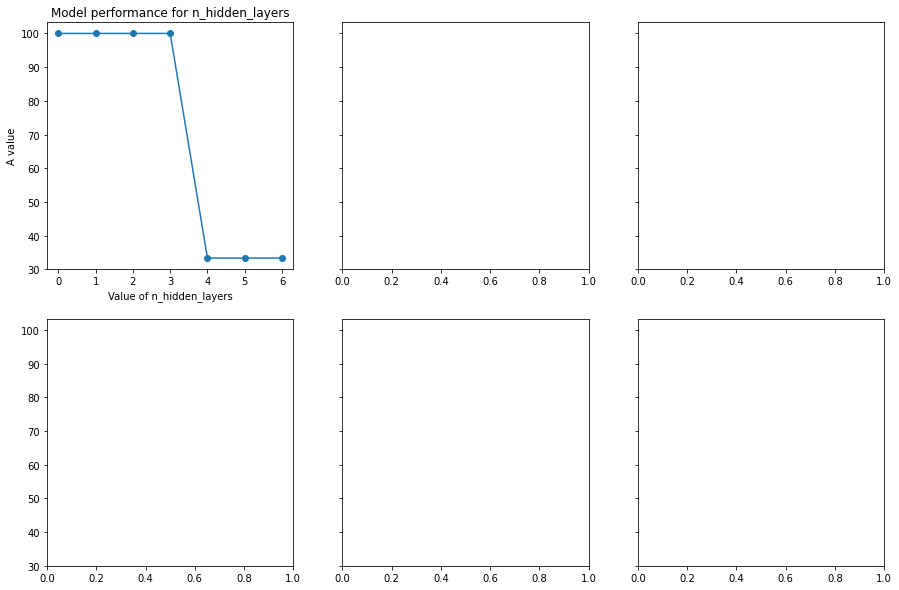

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Using the functions above, we will now proceed to plot for all parameters
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(15,10))
for i, varname in enumerate(NAMES):
    # Acquire the data
    var_data = get_by_var(data, varname)
    
    col = i % 3
    row = i // 3
    
    # Plot the stuff
    xs = [elem[0] for elem in var_data]
    ys = [elem[1] for elem in var_data]
    ys = [get_quality(y) for y in ys]
    
    ax[row, col].set_title(f"Model performance for {varname}")
    ax[row, col].set_xlabel(f"Value of {varname}")
    ax[row, col].set_ylabel("A value")
    ax[row, col].plot(range(len(xs)), [y[0] for y in ys], '-o', label="Accuracy")
    ax[row, col].plot(range(len(xs)), [y[1][1] for y in ys], '-o', label="Performance loss", secondary_y=True)
    ax[row, col].set_xticks(range(len(xs)))
    ax[row, col].set_xticklabels(xs)
    ax[row, col].grid()
    ax[row, col].legend()